In [1722]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

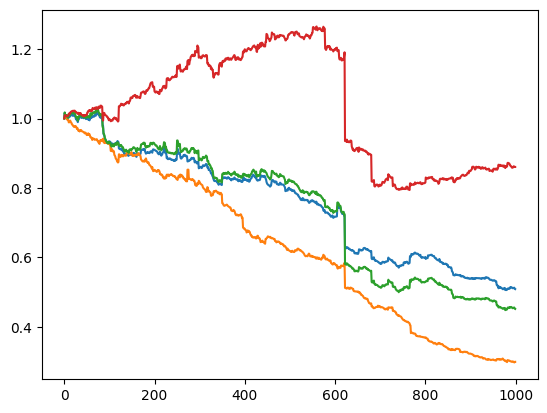

In [1723]:
n = 4
n_steps = 1000

A = np.random.randn(n, n)
cov_matrix = np.dot(A, A.T)/(n_steps**2)
mean_vec = np.random.randn(n)/n_steps

r_l = scipy.stats.multivariate_t(mean_vec, cov_matrix, df=2).rvs(n_steps).T
v_l = np.exp(r_l.cumsum(axis=1))
interest_rates = np.random.uniform(0.05, 0.5, size=(n, n_steps))/n_steps

r_b = - r_l - interest_rates
v_b = np.exp(r_b.cumsum(axis=1))
plt.plot(v_l.T)


In [1724]:
h = np.ones(n)*0.9
m = np.ones(n)*0.8

buffer = 0.0 # percentage of borrowing power reverse as buffer

w,x,y,z,a,b = 1.0,1.0,4.0,1.0,4.0,1.5

c = np.array([w, x, 0, 0])
c /= sum(c) # normalise to one

w_b = np.array([0, 0, y, z])
w_b /= sum(w_b) # normalise to one
w_b *= sum(c*m) # normalise to max borrowing power
w_b *= 1-buffer # normalise to buffered borrowing power

y = np.array([a, b, 0, 0])
y /= sum(y) 
y *= sum(w_b) 

w_l = c + y

healthFactor0 = sum(w_l*h) / sum(w_b)
healthFactor0, w_l, w_b, sum(w_l-w_b)

(2.025,
 array([1.08181818, 0.71818182, 0.        , 0.        ]),
 array([0.  , 0.  , 0.64, 0.16]),
 1.0)

In [1725]:
health_factors = []
collateral_value = []
borrowings_value = []
LB = 0.05
portfolio_value = []

from collections import defaultdict

liq_counts = defaultdict(int)

# Calculate health factor over time
for t in range(n_steps):
    # Compute new portfolio weights
    w_l *= np.exp(r_l[:,t]) 
    w_b *= np.exp(r_b[:,t])

    # Calculate health factor at time step t
    collateral = np.sum(w_l)
    borrowings = np.sum(w_b)
    health_factor_t = np.sum(w_l*h) / borrowings

    while (health_factor_t < 1) and (collateral > 0):
        print(t, 'before:', w_l, w_b)

        liq_counts[t] += 1
        
        i = np.argmax(w_b)
        j = np.argmax(w_l)
        
        repay = w_b[i]/2
        cease = repay*(1+LB)
        
        if cease > w_l[j]:
            cease = w_l[j]
            repay = cease / (1 + LB)
        
        w_b[i] -= repay
        w_l[j] -= cease
        collateral = np.sum(w_l)
        borrowings = np.sum(w_b)
        health_factor_t = np.sum(w_l*h) / borrowings
        print(t, 'after: ', w_l, w_b)
    
    health_factors.append(health_factor_t)
    collateral_value.append(collateral)
    borrowings_value.append(borrowings)
    portfolio_value.append(sum(w_l-w_b))
    
    if portfolio_value[-1] <= 0: break


622 before: [0.67980848 0.36778795 0.         0.        ] [0.         0.         0.9276811  0.14423958]
622 after:  [0.1927759  0.36778795 0.         0.        ] [0.         0.         0.46384055 0.14423958]
622 before: [0.1927759  0.36778795 0.         0.        ] [0.         0.         0.46384055 0.14423958]
622 after:  [0.1927759  0.12427166 0.         0.        ] [0.         0.         0.23192028 0.14423958]
622 before: [0.1927759  0.12427166 0.         0.        ] [0.         0.         0.23192028 0.14423958]
622 after:  [0.07101776 0.12427166 0.         0.        ] [0.         0.         0.11596014 0.14423958]
622 before: [0.07101776 0.12427166 0.         0.        ] [0.         0.         0.11596014 0.14423958]
622 after:  [0.07101776 0.04854588 0.         0.        ] [0.         0.         0.11596014 0.07211979]
622 before: [0.07101776 0.04854588 0.         0.        ] [0.         0.         0.11596014 0.07211979]
622 after:  [0.01013868 0.04854588 0.         0.        ] [0.   

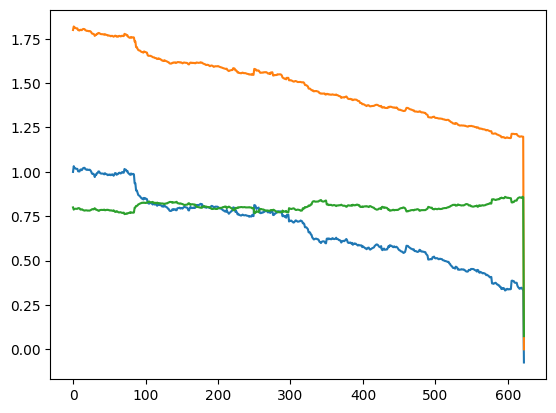

In [1726]:
plt.plot(portfolio_value)
plt.plot(collateral_value)
plt.plot(borrowings_value)

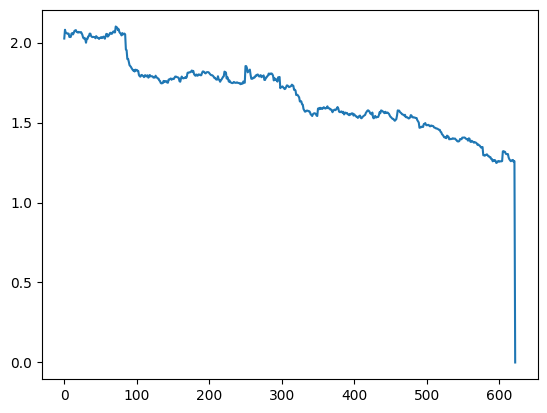

In [1727]:
plt.plot(health_factors)

In [1728]:
portfolio_value = np.array(portfolio_value)

# Calculate portfolio log returns using numpy (vectorized)
portfolio_returns = np.log(portfolio_value[1:] / portfolio_value[:-1])

mean = np.nanmean(portfolio_returns)
std = np.nanstd(portfolio_returns)
print(mean, std, mean/std)

-0.0017314211777124558 0.011733800564215474 -0.14755842902194574


/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_44758/451054957.py:4: RuntimeWarning: invalid value encountered in log
  portfolio_returns = np.log(portfolio_value[1:] / portfolio_value[:-1])


In [1729]:
portfolio_value = np.array(portfolio_value)

# Calculate portfolio log returns using numpy (vectorized)
portfolio_returns = np.log(portfolio_value[1:] / portfolio_value[:-1])

mean = np.nanmean(portfolio_returns)
std = np.nanstd(portfolio_returns)
print(mean, std, mean/std)

-0.0017314211777124558 0.011733800564215474 -0.14755842902194574


/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_44758/451054957.py:4: RuntimeWarning: invalid value encountered in log
  portfolio_returns = np.log(portfolio_value[1:] / portfolio_value[:-1])


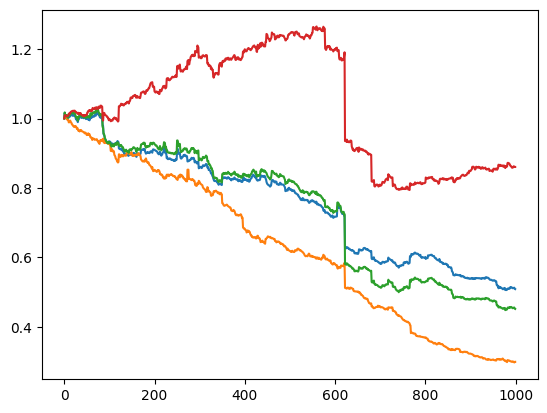

In [1730]:
plt.plot(v_l.T)

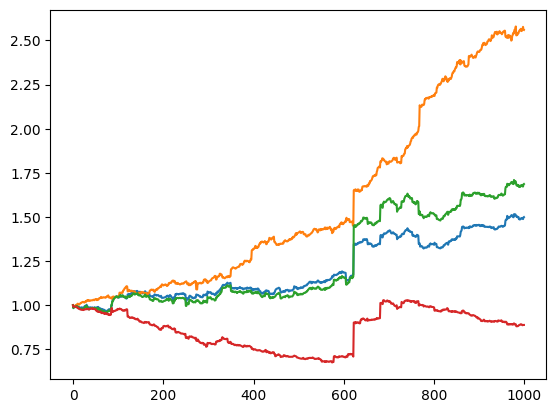

In [1731]:
plt.plot(v_b.T)

In [1829]:
def projection1(_c, _w_b, _y):
    _c = np.clip(_c, 0, None)
    _w_b = np.clip(_w_b, 0, None)
    _y = np.clip(_y, 0, None)
    
    j = np.argmax(_c+_y)
        
    # no long short on the same asset at the same time
    idx1 = np.logical_and(_c*_w_b != 0, _c + _y < _w_b)
    _c[idx1] = 0
    
    if sum(_c) == 0:
        _c[j] = 1

    idx2 = _c*_w_b != 0
    _w_b[idx2] = 0
    
    _c /= sum(_c) # normalise to one
    
    tb = sum(_w_b) # total borrowing
    tbp = sum(_c*m) # total borrowing power
    
    if tb > tbp:
        _w_b *= tbp/tb # normalise to max borrowing power
        
    # no long short on the same asset at the same time
    idx3 = _y*_w_b != 0
    _y[idx3] = 0

    if sum(_y) == 0:
        _y[_c>0] = 1
    
    _y /= sum(_y) 
    _y *= sum(_w_b)

    return _c, _w_b, _y

def projection2(_c, _w_b, _y, dc, dw_b, dy):
    _c = np.clip(_c, 0, None)
    _w_b = np.clip(_w_b, 0, None)
    _y = np.clip(_y, 0, None)
        
    # no long short on the same asset at the same time by taking the steepest gradient
    idx1 = np.logical_and(_c*_w_b != 0, dc + dy < dw_b)
    _c[idx1]  = 0

    idx2 = np.logical_and(_c*_w_b != 0, dc + dy >= dw_b)
    _w_b[idx2] = 0
    
    _c /= sum(_c) # normalise to one
    
    tb = sum(_w_b) # total borrowing
    tbp = sum(_c*m) # total borrowing power
    
    if tb > tbp:
        _w_b *= tbp/tb # normalise to max borrowing power
        
    # no long short on the same asset at the same time
    idx3 = _y*_w_b != 0
    _y[idx3] = 0
    
    if sum(_y) == 0:
        _y[_c>0] = 1
    _y /= sum(_y) 
    _y *= sum(_w_b)

    return _c, _w_b, _y


In [1830]:
c = np.array([7,0,0,4], dtype=float)
w_b = np.array([1,1,1,6], dtype=float)
y = np.array([4,0,0,4], dtype=float)

new_c, new_w_b, new_y = projection1(c, w_b, y)
new_c, new_w_b, new_y

(array([0.63636364, 0.        , 0.        , 0.36363636]),
 array([0. , 0.4, 0.4, 0. ]),
 array([0.4, 0. , 0. , 0.4]))

In [1831]:
dc = np.array([5,2,3,4])
dw_b = np.array([-400,300,2,1])
dy = np.array([100,1,1,1])

new_c, new_w_b, new_y = projection2(c, w_b, y, dc, dw_b, dy)
new_c, new_w_b, new_y

(array([0.63636364, 0.        , 0.        , 0.36363636]),
 array([0. , 0.4, 0.4, 0. ]),
 array([0.4, 0. , 0. , 0.4]))

In [1832]:
new_w_l = new_c + new_y
new_w_l, new_w_b

(array([1.03636364, 0.        , 0.        , 0.76363636]),
 array([0. , 0.4, 0.4, 0. ]))

In [1833]:
sum(new_w_l*h)/sum(new_w_b)

2.025

In [1834]:
sum(new_w_l - new_w_b)

1.0

In [1835]:
def genPortfolioPerformance(w_l, w_b, returnPortfolioValue=False):
    w_l = w_l.copy()
    w_b = w_b.copy()

    liq_counts = defaultdict(int)
    health_factors = []
    collateral_value = []
    borrowings_value = []
    LB = 0.05
    portfolio_value = []

    # Calculate health factor over time
    for t in range(n_steps):
        # Compute new portfolio weights
        w_l *= np.exp(r_l[:,t]) 
        w_b *= np.exp(r_b[:,t])

        # Calculate health factor at time step t
        collateral = np.sum(w_l)
        borrowings = np.sum(w_b)
        health_factor_t = np.sum(w_l*h) / borrowings

        while (health_factor_t < 1) and (collateral > 0):
            # print(t, 'before:', w_l, w_b)

            liq_counts[t] += 1
            
            i = np.argmax(w_b)
            j = np.argmax(w_l)
            
            repay = w_b[i]/2
            cease = repay*(1 + LB)
            
            if cease > w_l[j]:
                cease = w_l[j]
                repay = cease / (1 + LB)
            
            w_b[i] -= repay
            w_l[j] -= cease
            collateral = np.sum(w_l)
            borrowings = np.sum(w_b)
            if borrowings != 0:
                health_factor_t = np.sum(w_l*h) / borrowings
            else:
                health_factor_t = inf
            # print(t, 'after: ', w_l, w_b)
        
        health_factors.append(health_factor_t)
        collateral_value.append(collateral)
        borrowings_value.append(borrowings)
        portfolio_value.append(sum(w_l-w_b))
        
        if portfolio_value[-1] <= 0: break

    
    if returnPortfolioValue:
        return portfolio_value, health_factors
    else:
        portfolio_value = np.array(portfolio_value)
        portfolio_returns = np.log(portfolio_value[1:] / portfolio_value[:-1])

        mean = np.nanmean(portfolio_returns)
        std = np.nanstd(portfolio_returns)
        return mean/(std/2)

In [1842]:
epsilon = 0.00000001

def genGradient(c0, w_b0, y0):
    c0, w_b0, y0 = projection1(c0, w_b0, y0)

    res0 = genPortfolioPerformance(c0 + y0, w_b0)

    dFdc = []

    for i in range(len(c0)):
        new_c = c0.copy()
        new_w_b = w_b0.copy()
        new_y = y0.copy()

        new_c[i] += epsilon
        # new_w_b[i] = 0

        # new_c, new_w_b, new_y = projection1(new_c, new_w_b, new_y)
        res1 = genPortfolioPerformance(new_c + new_y, new_w_b)
        
        dFdc.append((res1-res0)/epsilon)

    dFdw_b = []

    for i in range(len(w_b)):
        new_c = c0.copy()
        new_w_b = w_b0.copy()
        new_y = y0.copy()

        # new_c[i] = 0
        new_w_b[i] += epsilon

        # new_c, new_w_b, new_y = projection1(new_c, new_w_b, new_y)
        res1 = genPortfolioPerformance(new_c + new_y, new_w_b)
        
        dFdw_b.append((res1-res0)/epsilon)

    dFdy = []

    for i in range(len(w_b)):
        new_c = c0.copy()
        new_w_b = w_b0.copy()
        new_y = y0.copy()

        new_y[i] += epsilon
        # new_w_b[i] = 0 
        # if sum(new_w_b) == 0:
        #     new_w_b[:] = epsilon/(len(new_w_b)-1)
        #     new_w_b[i] = 0 

        # new_c, new_w_b, new_y = projection1(new_c, new_w_b, new_y)
        res1 = genPortfolioPerformance(new_c + new_y, new_w_b)
        
        dFdy.append((res1-res0)/epsilon)

    dFdc = np.array(dFdc)
    dFdw_b = np.array(dFdw_b)
    dFdy = np.array(dFdy)
    return dFdc, dFdw_b, dFdy, res0

In [1850]:
c0, w_b0, y0 = projection1(c0, w_b0, y0)

dFdw_b = []

res0 = genPortfolioPerformance(c0 + y0, w_b0)
i = 0
new_c = c0.copy()
new_w_b = w_b0.copy()
new_y = y0.copy()

# new_c[i] = 0
new_w_b[i] += epsilon

# new_c, new_w_b, new_y = projection1(new_c, new_w_b, new_y)
res1 = genPortfolioPerformance(new_c + new_y, new_w_b)

dFdw_b.append((res1-res0)/epsilon)


/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_44758/2094095189.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  health_factor_t = np.sum(w_l*h) / borrowings


In [1857]:
new_w_b

array([1.e-08, 0.e+00, 0.e+00, 0.e+00])

In [1846]:
c0   = np.array([0,1,0,1], dtype=float)
w_b0 = np.array([0,0,0,0], dtype=float)
y0   = np.array([0,0,0,0], dtype=float)

c0, w_b0, y0 = projection1(c0, w_b0, y0)

c, w_b, y = c0.copy(), w_b0.copy(), y0.copy()
gradient = genGradient(c, w_b, y)

new_c, new_w_b, new_y = projection2(new_c, new_w_b, new_y, gradient[0], gradient[1], gradient[2])


c0, w_b0, y0 , new_c, new_w_b, new_y, gradient[0], gradient[1], gradient[2]

/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_44758/2094095189.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  health_factor_t = np.sum(w_l*h) / borrowings


(array([0. , 0.5, 0. , 0.5]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0.        , 0.45036853, 0.        , 0.54963147]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([-0.09142731, -0.16128909, -0.06769568,  0.16128903]),
 array([-0.06403808, -0.42224557, -0.03524371,  0.1907729 ]),
 array([-0.09142731, -0.16128909, -0.06769568,  0.16128903]))

In [1840]:
eta = 0.01
stopping = 0.00001
K = 10000

c0   = np.array([1,1,1,1], dtype=float)
w_b0 = np.array([0,0,0,0], dtype=float)
y0   = np.array([0,0,0,0], dtype=float)

c0, w_b0, y0 = projection1(c0, w_b0, y0)

c, w_b, y = c0.copy(), w_b0.copy(), y0.copy()
gradient = genGradient(c, w_b, y)


best = [-np.inf, 0,0,0]

k=0
while k<K:
    new_c   = c + eta*gradient[0]
    new_w_b = w_b + eta*gradient[1]
    new_y   = y + eta*gradient[2]
    new_c, new_w_b, new_y = projection2(new_c, new_w_b, new_y, gradient[0], gradient[1], gradient[2])
    
    if k%20 == 0: print(k, gradient[-1], new_c, new_w_b, new_y, best[0])

    if (np.sum(np.abs(new_c - c)) < stopping) and (np.sum(np.abs(new_w_b - w_b)) < stopping) and (np.sum(np.abs(new_y - y)) < stopping):
        c, w_b, y = new_c, new_w_b, new_y
        break
    
    c, w_b, y = new_c, new_w_b, new_y
    gradient = genGradient(c, w_b, y)
    
    if gradient[-1] > best[0]:
        best = [gradient[-1], c, w_b, y]
    
    k += 1


/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_44758/2094095189.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  health_factor_t = np.sum(w_l*h) / borrowings


0 -0.14231380563389592 [0.         0.49838711 0.         0.50161289] [0. 0. 0. 0.] [0. 0. 0. 0.] -inf
20 -0.1324411322992135 [0.         0.46700793 0.         0.53299207] [0. 0. 0. 0.] [0. 0. 0. 0.] -0.1324411322992135


KeyboardInterrupt: 

In [1821]:
c, w_b, y = best[1],  best[2],  best[3]

V_0 = genPortfolioPerformance(c0+y0, w_b0, returnPortfolioValue=True)[0]
V_star = genPortfolioPerformance(c+y, w_b, returnPortfolioValue=True)[0]

V_0 = np.array(V_0)
V_star = np.array(V_star)

R_0 = np.log(V_0[1:]/V_0[:-1])
R_star = np.log(V_star[1:]/V_star[:-1])

/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_44758/2094095189.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  health_factor_t = np.sum(w_l*h) / borrowings


In [1822]:
# np.mean(R_0), np.mean(R_star), np.std(R_0), np.std(R_star)

np.mean(R_0)/ np.std(R_0), np.mean(R_star)/ np.std(R_star)

(-0.08989975973562042, -0.033725105682129636)

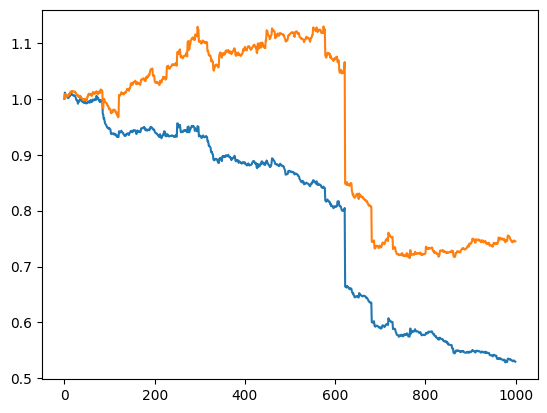

In [1823]:
plt.plot(V_0)
plt.plot(V_star)